<a href="https://colab.research.google.com/github/luca-arts/seeingtheimperceptible/blob/main/notebooks/syntheticPoseImageGeneration/tests/Aphantasia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text to Image tool

Part of [Aphantasia](https://github.com/eps696/aphantasia) suite, made by Vadim Epstein [[eps696](https://github.com/eps696)]  
Based on [CLIP](https://github.com/openai/CLIP) + FFT from [Lucent](https://github.com/greentfrapp/lucent).  
Thanks to [Ryan Murdock](https://twitter.com/advadnoun), [Jonathan Fly](https://twitter.com/jonathanfly), [Hannu Toyryla](https://twitter.com/htoyryla), [@eduwatch2](https://twitter.com/eduwatch2) for ideas.

## Features 
* generates massive detailed imagery, a la deepdream 
* high resolution (up to 12K on RTX 3090)
* directly parameterized with [FFT](https://github.com/greentfrapp/lucent/blob/master/lucent/optvis/param/spatial.py) [Fourier] or DWT [wavelets] (no pretrained GANs)
* various CLIP models (including multi-language from [SBERT](https://sbert.net))
* starting/resuming process from saved FFT parameters or from an image
* complex requests:
  * image and/or text as main prompts  
   (composition similarity controlled with [LPIPS](https://github.com/richzhang/PerceptualSimilarity) loss)
  * separate text prompts for image style and to subtract (suppress) topics
  * criteria inversion (show "the opposite")


**Run the cell below after each session restart**

Mark `resume` and upload `.pt` file, if you're resuming from the saved snapshot. Or you can simply upload any image to start from.  
Resolution settings below will be overwritten in this case. 

In [2]:
#@title General setup

# !pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2 torchvision==0.8.2 ftfy==5.8 regex
!pip install ftfy==5.8 transformers==4.6.0
!pip install gputil ffpb 

import os
import io
import time
from math import exp
import random
import imageio
import numpy as np
import PIL
from base64 import b64encode
# import moviepy, moviepy.editor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable

from IPython.display import HTML, Image, display, clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import ipywidgets as ipy
from google.colab import output, files

import warnings
warnings.filterwarnings("ignore")

!pip install git+https://github.com/openai/CLIP.git --no-deps
import clip
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
!pip install kornia
import kornia
!pip install lpips
import lpips

!pip install PyWavelets==1.1.1
!pip install git+https://github.com/fbcotter/pytorch_wavelets
import pywt
from pytorch_wavelets import DWTForward, DWTInverse
# from pytorch_wavelets import DTCWTForward, DTCWTInverse

%cd /content
!pip install git+https://github.com/eps696/aphantasia
from aphantasia.image import to_valid_rgb, fft_image, img2fft, dwt_image, img2dwt, init_dwt, dwt_scale
from aphantasia.utils import slice_imgs, derivat, pad_up_to, basename, img_list, img_read, plot_text, txt_clean, checkout, old_torch
from aphantasia import transforms
from aphantasia.progress_bar import ProgressIPy as ProgressBar

clear_output()

resume = False #@param {type:"boolean"}
if resume:
  resumed = files.upload()
  resumed_filename = list(resumed)[0]
  resumed_bytes = list(resumed.values())[0]

def makevid(seq_dir, size=None):
  out_sequence = seq_dir + '/%04d.jpg'
  out_video = seq_dir + '.mp4'
  print('.. generating video ..')
  !ffmpeg -y -v warning -i $out_sequence -crf 20 $out_video
  # moviepy.editor.ImageSequenceClip(img_list(seq_dir), fps=25).write_videofile(out_video, verbose=False)
  data_url = "data:video/mp4;base64," + b64encode(open(out_video,'rb').read()).decode()
  wh = '' if size is None else 'width=%d height=%d' % (size, size)
  return """<video %s controls><source src="%s" type="video/mp4"></video>""" % (wh, data_url)

# Hardware check
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
import GPUtil as GPU
gpu = GPU.getGPUs()[0]
!nvidia-smi -L
print("GPU RAM {0:.0f}MB | Free {1:.0f}MB)".format(gpu.memoryTotal, gpu.memoryFree))
print('\nDone!')

GPU 0: Tesla T4 (UUID: GPU-916c7f7c-a0a4-ce64-8be5-2428c4967bc3)
GPU RAM 15109MB | Free 15106MB)

Done!


Type some `text` and/or upload some image to start.  
Describe `style`, which you'd like to apply to the imagery.  
Put to `subtract` the topics, which you would like to avoid in the result.  
`invert` the whole criteria, if you want to see "the totally opposite".

Options for non-English languages (use only one of them!):  
`multilang` = use multi-language model, trained with ViT  
`translate` = use Google translate (works with any visual model)

In [8]:
#@title Input

text = "butterfly" #@param {type:"string"}
style = "warhol" #@param {type:"string"}
subtract = "" #@param {type:"string"}
multilang = False #@param {type:"boolean"}
translate = False #@param {type:"boolean"}
invert = False #@param {type:"boolean"}
upload_image = False #@param {type:"boolean"}

if translate:
  !pip3 install googletrans==3.1.0a0
  clear_output()
  from googletrans import Translator
  translator = Translator()

if upload_image:
  uploaded = files.upload()

workdir = '_out'
tempdir = os.path.join(workdir, '%s-%s' % (txt_clean(text)[:50], txt_clean(style)[:50]))

### Settings

Select visual `model` (results do vary!). I prefer ViT for consistency (and it's the only native multi-language option).  
`align` option is about composition. `uniform` looks most adequate, `overscan` can make semi-seamless tileable texture.  
`use_wavelets` for DWT encoding instead of FFT. Select `wave` method if needed.  
`aug_transform` applies some augmentations, inhibiting image fragmentation & "graffiti" printing (slower, yet recommended).  
`sync` value adds LPIPS loss between the output and input image (if there's one), allowing to "redraw" it with controlled similarity.  
Decrease `samples` if you face OOM (it's the main RAM eater).  

Setting `steps` much higher (1000-..) will elaborate details and make tones smoother, but may start throwing texts like graffiti.  
Tune `decay` (compositional softness) and `sharpness`, `colors` (saturation) and `contrast` as needed.  

Experimental tricks:  
`aug_noise` augmentation, `macro` (from 0 to 1) and `progressive_grow` (read more [here](https://github.com/eps696/aphantasia/issues/2)) may boost bigger forms, making composition less disperse.  
`no_text` tries to remove "graffiti" by subtracting plotted text prompt  
`enhance` boosts training consistency (of simultaneous samples) and steps progress. good start is 0.1~0.2.  

 using 200 samples
 main topic: butterfly
 style: warhol


Output()

.. generating video ..


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

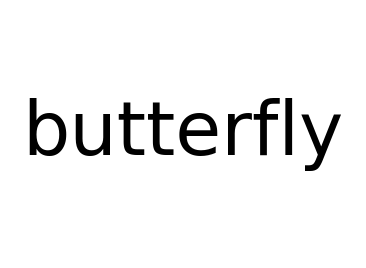

In [9]:
#@title Generate

!rm -rf $tempdir
os.makedirs(tempdir, exist_ok=True)

sideX = 600 #@param {type:"integer"}
sideY = 400 #@param {type:"integer"}
#@markdown > Config
model = 'ViT-B/32' #@param ['ViT-B/16', 'ViT-B/32', 'RN101', 'RN50x16', 'RN50x4', 'RN50']
align = 'uniform' #@param ['central', 'uniform', 'overscan']
use_wavelets = True #@param {type:"boolean"}
wave = 'coif2' #@param ['db2', 'db3', 'db4', 'coif1', 'coif2', 'coif3', 'coif4']
aug_transform = True #@param {type:"boolean"}
sync =  0.4 #@param {type:"number"}
#@markdown > Look
decay = 1.5 #@param {type:"number"}
colors = 1.5 #@param {type:"number"}
contrast = 0.9 #@param {type:"number"}
sharpness = 0.3 #@param {type:"number"}
#@markdown > Training
steps =  600#@param {type:"integer"}
samples = 200 #@param {type:"integer"}
learning_rate = .05 #@param {type:"number"}
save_freq = 1 #@param {type:"integer"}
#@markdown > Tricks
aug_noise = 0.2 #@param {type:"number"}
no_text = 0.07 #@param {type:"number"}
enhance = 0.1 #@param {type:"number"}
macro = 0.4 #@param {type:"number"}
progressive_grow = True #@param {type:"boolean"}
if multilang: model = 'ViT-B/32' # sbert model is trained with ViT
diverse = -enhance
expand = abs(enhance)

shape = [1, 3, sideY, sideX]

if use_wavelets:
  if resume is True:
    if os.path.splitext(resumed_filename)[1].lower()[1:] in ['jpg','png','tif','bmp']:
      img_in = imageio.imread(resumed_bytes)
      init_pt = img2dwt(img_in, wave, 1.5)
      scale = dwt_scale(init_pt, sharpness)
      for i in range(len(init_pt)-1):
        init_pt[i+1] /= (scale[i] * 10)
      sideY, sideX = img_in.shape[0], img_in.shape[1]
    else:
      init_pt = torch.load(io.BytesIO(resumed_bytes))
      # init_pt = [y.detach().cuda() for y in init_pt]
  else:
    init_pt, _, _, _ = init_dwt(None, shape, wave, colors)

  shape = [1, 3, sideY, sideX]
  params, image_f, _ = dwt_image(shape, wave, sharpness, colors, init_pt)

else:
  if resume is True:
    if os.path.splitext(resumed_filename)[1].lower()[1:] in ['jpg','png','tif','bmp']:
      img_in = imageio.imread(resumed_bytes)
      init_pt = img2fft(img_in, 1.5, 1.5) * 0.1
    else:
      init_pt = torch.load(io.BytesIO(resumed_bytes))
      if isinstance(init_pt, list): init_pt = init_pt[0]
  #  init_pt = init_pt.cuda()
    sideY, sideX = init_pt.shape[2], (init_pt.shape[3]-1)*2
  else:
    params_shape = [1, 3, sideY, sideX//2+1, 2]
    init_pt = torch.randn(*params_shape) * 0.01

  shape = [1, 3, sideY, sideX]
  params, image_f, _ = fft_image(shape, 1, decay, init_pt)

image_f = to_valid_rgb(image_f, colors = colors)

if progressive_grow is True:
  lr1 = learning_rate * 2
  lr0 = lr1 * 0.01
else:
  lr0 = learning_rate
optimizer = torch.optim.AdamW(params, lr0, weight_decay=0.01, amsgrad=True)

if len(subtract) > 0:
  samples = int(samples * 0.75)
print(' using %d samples' % samples)

model_clip, _ = clip.load(model, jit=old_torch())
modsize = model_clip.visual.input_resolution
xmem = {'ViT-B/16':0.25, 'RN50':0.5, 'RN50x4':0.16, 'RN50x16':0.06, 'RN101':0.33}
if model in xmem.keys():
  samples = int(samples * xmem[model])

if multilang is True:
    model_lang = SentenceTransformer('clip-ViT-B-32-multilingual-v1').cuda()

def enc_text(txt):
  if multilang is True:
    emb = model_lang.encode([txt], convert_to_tensor=True, show_progress_bar=False)
  else:
    emb = model_clip.encode_text(clip.tokenize(txt).cuda())
  return emb.detach().clone()

if diverse != 0:
  samples = int(samples * 0.5)
if sync > 0 and upload_image:
  samples = int(samples * 0.6)
        
sign = 1. if invert is True else -1.
if aug_transform is True:
  trform_f = transforms.transforms_fast
  samples = int(samples * 0.95)
else:
  trform_f = transforms.normalize()

if upload_image:
  in_img = list(uploaded.values())[0]
  print(' image:', list(uploaded)[0])
  img_in = torch.from_numpy(imageio.imread(in_img).astype(np.float32)/255.).unsqueeze(0).permute(0,3,1,2).cuda()[:,:3,:,:]
  in_sliced = slice_imgs([img_in], samples, modsize, transforms.normalize(), align)[0]
  img_enc = model_clip.encode_image(in_sliced).detach().clone()
  if sync > 0:
    align = 'overscan'
    sim_loss = lpips.LPIPS(net='vgg', verbose=False).cuda()
    sim_size = [sideY//4, sideX//4]
    img_in = F.interpolate(img_in, sim_size).float()
    # img_in = F.interpolate(img_in, (sideY, sideX)).float()
  else:
    del img_in
  del in_sliced; torch.cuda.empty_cache()

if len(text) > 0:
  print(' main topic:', text)
  if translate:
    text = translator.translate(text, dest='en').text
    print(' translated to:', text) 
  txt_enc = enc_text(text)
  if no_text > 0:
    txt_plot = torch.from_numpy(plot_text(text, modsize)/255.).unsqueeze(0).permute(0,3,1,2).cuda()
    txt_plot_enc = model_clip.encode_image(txt_plot).detach().clone()

if len(style) > 0:
  print(' style:', style)
  if translate:
    style = translator.translate(style, dest='en').text
    print(' translated to:', style) 
  txt_enc2 = enc_text(style)

if len(subtract) > 0:
  print(' without:', subtract)
  if translate:
    subtract = translator.translate(subtract, dest='en').text
    print(' translated to:', subtract) 
  txt_enc0 = enc_text(subtract)

if multilang is True: del model_lang

def save_img(img, fname=None):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1,2,0))  
  img = np.clip(img*255, 0, 255).astype(np.uint8)
  if fname is not None:
    imageio.imsave(fname, np.array(img))
    imageio.imsave('result.jpg', np.array(img))

def checkout(num):
  with torch.no_grad():
    img = image_f(contrast=contrast).cpu().numpy()[0]
    # empirical tone mapping
    if sync > 0 and upload_image:
      img = img **1.3 
    if sharpness != 0:
      img = img ** (1 + sharpness/2.)
  save_img(img, os.path.join(tempdir, '%04d.jpg' % num))
  outpic.clear_output()
  with outpic:
    display(Image('result.jpg'))

prev_enc = 0
def train(i):
  loss = 0
  noise = aug_noise * torch.randn(1, 1, *params[0].shape[2:4], 1).cuda() if aug_noise > 0 else None
  img_out = image_f(noise)
  img_sliced = slice_imgs([img_out], samples, modsize, trform_f, align, macro=macro)[0]
  out_enc = model_clip.encode_image(img_sliced)

  if len(text) > 0: # input text
    loss += sign * torch.cosine_similarity(txt_enc, out_enc, dim=-1).mean()
    if no_text > 0:
      loss -= sign * no_text * torch.cosine_similarity(txt_plot_enc, out_enc, dim=-1).mean()
  if len(style) > 0: # input text - style
    loss += sign * 0.5 * torch.cosine_similarity(txt_enc2, out_enc, dim=-1).mean()
  if len(subtract) > 0: # subtract text
    loss -= sign * torch.cosine_similarity(txt_enc0, out_enc, dim=-1).mean()
  if upload_image:
    loss += sign * 0.5 * torch.cosine_similarity(img_enc, out_enc, dim=-1).mean()
  if sync > 0 and upload_image: # image composition sync
    prog_sync = (steps - i) / steps 
    loss += prog_sync * sync * sim_loss(F.interpolate(img_out, sim_size).float(), img_in, normalize=True).squeeze()
  if sharpness != 0 and not use_wavelets: # mode = scharr|sobel|default
    loss -= sharpness * derivat(img_out, mode='sobel')
    # loss -= sharpness * derivat(img_sliced, mode='scharr')
  if diverse != 0:
    img_sliced = slice_imgs([image_f(noise)], samples, modsize, trform_f, align, macro=macro)[0]
    out_enc2 = model_clip.encode_image(img_sliced)
    loss += diverse * torch.cosine_similarity(out_enc, out_enc2, dim=-1).mean()
    del out_enc2; torch.cuda.empty_cache()
  if expand > 0:
    global prev_enc
    if i > 0:
      loss += expand * torch.cosine_similarity(out_enc, prev_enc, dim=-1).mean()
    prev_enc = out_enc.detach()
  del img_out, img_sliced, out_enc; torch.cuda.empty_cache()

  if progressive_grow is True:
    lr_cur = lr0 + (i / steps) * (lr1 - lr0)
    for g in optimizer.param_groups: 
      g['lr'] = lr_cur

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  if i % save_freq == 0:
    checkout(i // save_freq)

outpic = ipy.Output()
outpic

pbar = ProgressBar(steps)
for i in range(steps):
  train(i)
  _ = pbar.upd()

HTML(makevid(tempdir))
torch.save(params, tempdir + '.pt')
files.download(tempdir + '.pt')
files.download(tempdir + '.mp4')
